# **MCAS Score Analysis: 10th Grade Performance Across Massachusetts**

This project analyzes trends and disparities in 10th-grade MCAS scores in Math, English, and Science across Massachusetts (2019–2024). The goal is to uncover patterns by geography, equity groups, and school characteristics to inform policy and resource decisions.

## **Environment Setup & Imports**

In [1]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Set project directory
project_dir = "/content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis"
data_dir = os.path.join(project_dir, "data files")
output_dir = os.path.join(project_dir, "visuals & reports")

# Create folders if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

# For modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load District-Level MCAS Files (2019–2024)**

In [2]:
# Define file names (exact matches from your uploads)
mcas_files = {
    2019: os.path.join(data_dir, "mcas_district_2019_grade10_allstudents.xlsx"),
    2021: os.path.join(data_dir, "mcas_district_2021_grade10_allstudents.xlsx"),
    2022: os.path.join(data_dir, "mcas_district_2022_grade10_allstudents.xlsx"),
    2023: os.path.join(data_dir, "mcas_district_2023_grade10_allstudents.xlsx"),
    2024: os.path.join(data_dir, "mcas_district_2024_grade10_allstudents.xlsx")
}

# Load all files with headers (row 2)
mcas_data_by_year = {}

for year, path in mcas_files.items():
    try:
        df = pd.read_excel(path, header=1)
        mcas_data_by_year[year] = df
        print(f"{year} loaded: {df.shape[0]} rows")
    except Exception as e:
        print(f"Error loading {year}: {e}")


2019 loaded: 608 rows
2021 loaded: 604 rows
2022 loaded: 902 rows
2023 loaded: 907 rows
2024 loaded: 910 rows


## **Compare Column Headers Across Years**

In [3]:
# Print the first few column names for each year to compare formats
for year, df in mcas_data_by_year.items():
    print(f"\n--- {year} Columns ---")
    print(df.columns.tolist())


--- 2019 Columns ---
['District Name', 'District Code', 'Subject', 'M+E #', 'M+E %', 'E #', 'E %', 'M #', 'M %', 'PM #', 'PM %', 'NM #', 'NM %', 'No. of Students Included', 'Avg. Scaled Score', 'SGP', 'Included In SGP']

--- 2021 Columns ---
['District Name', 'District Code', 'Subject', 'M+E #', 'M+E %', 'E #', 'E %', 'M #', 'M %', 'PM #', 'PM %', 'NM #', 'NM %', 'No. of Students Included', 'Part. Rate %', 'Avg. Scaled Score', 'SGP', 'Included In SGP']

--- 2022 Columns ---
['District Name', 'District Code', 'Subject', 'M+E #', 'M+E %', 'E #', 'E %', 'M #', 'M %', 'PM #', 'PM %', 'NM #', 'NM %', 'No. of Students Included', 'Part. Rate %', 'Avg. Scaled Score', 'SGP', 'Included In SGP']

--- 2023 Columns ---
['District Name', 'District Code', 'Subject', 'M+E #', 'M+E %', 'E #', 'E %', 'M #', 'M %', 'PM #', 'PM %', 'NM #', 'NM %', 'No. of Students Included', 'Part. Rate %', 'Avg. Scaled Score', 'SGP', 'Included In SGP']

--- 2024 Columns ---
['District Name', 'District Code', 'Subject', 

## **Standardize Column Names and Combine Datasets**

In [4]:
# Define a function to standardize a single year's dataframe
def standardize_mcas_df(df, year):
    df = df.copy()
    df["year"] = year

    # Rename consistent columns
    df = df.rename(columns={
        "District Name": "district_name",
        "District Code": "district_code",
        "Subject": "subject",
        "Avg. Scaled Score": "avg_scaled_score",
        "SGP": "sgp",
        "No. of Students Included": "n_students",
        "Part. Rate %": "participation_rate"  # only in 2021–2024
    })

    # Add placeholder for years without participation_rate
    if "participation_rate" not in df.columns:
        df["participation_rate"] = np.nan

    return df[["year", "district_name", "district_code", "subject", "avg_scaled_score", "sgp", "n_students", "participation_rate"]]

# Apply to all years
standardized_dfs = []

for year, df in mcas_data_by_year.items():
    cleaned = standardize_mcas_df(df, year)
    standardized_dfs.append(cleaned)

# Combine all into one DataFrame
mcas_combined_df = pd.concat(standardized_dfs, ignore_index=True)
print("Combined MCAS dataset shape:", mcas_combined_df.shape)

# Preview
mcas_combined_df.head()

# Save to your data files folder
combined_path = os.path.join(data_dir, "mcas_combined_district_grade10_allstudents.csv")
mcas_combined_df.to_csv(combined_path, index=False)
print("Combined dataset saved to:", combined_path)


Combined MCAS dataset shape: (3931, 8)
Combined dataset saved to: /content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis/data files/mcas_combined_district_grade10_allstudents.csv


_This step selects consistent columns and renames them to lowercase snake_case. It also adds a `year` column and fills in missing `participation_rate` where not reported (2019)._

## **Load Combined File and Inspect Structure**

In [31]:
# Load the combined file
mcas_df = pd.read_csv(os.path.join(data_dir, "mcas_combined_district_grade10_allstudents.csv"))

# Quick checks
print("Shape:", mcas_df.shape)
print("\nColumns:")
print(mcas_df.columns)

# View structure
mcas_df.info()

# View sample
mcas_df.head()

Shape: (3931, 8)

Columns:
Index(['year', 'district_name', 'district_code', 'subject', 'avg_scaled_score',
       'sgp', 'n_students', 'participation_rate'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                3931 non-null   int64  
 1   district_name       3931 non-null   object 
 2   district_code       3931 non-null   int64  
 3   subject             3931 non-null   object 
 4   avg_scaled_score    3931 non-null   float64
 5   sgp                 2978 non-null   float64
 6   n_students          3931 non-null   object 
 7   participation_rate  3323 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 245.8+ KB


,year,district_name,district_code,subject,avg_scaled_score,sgp,n_students,participation_rate
0,2019,Abby Kelley Foster Charter Public (District),4450000,ELA,507.5,55.0,95,NaN
1,2019,Abby Kelley Foster Charter Public (District),4450000,MATH,505.2,70.1,95,NaN
2,2019,Abington,10000,ELA,506.6,46.4,150,NaN
3,2019,Abington,10000,MATH,504.9,48.6,151,NaN
4,2019,Academy Of the Pacific Rim Charter Public (Dis...,4120000,ELA,506.7,59.6,64,NaN


## **Investigate Missing Values**

In [32]:
# Missing values
mcas_df.isnull().sum()

,0
year,0
district_name,0
district_code,0
subject,0
avg_scaled_score,0
sgp,953
n_students,0
participation_rate,608


In [33]:
# --- Investigate missing SGP values ---
missing_sgp = mcas_df[mcas_df["sgp"].isnull()]

print("SGP Missing by Year:")
print(missing_sgp["year"].value_counts().sort_index())

print("\nSGP Missing by Subject:")
print(missing_sgp["subject"].value_counts())

# --- Investigate missing participation_rate values ---
missing_participation = mcas_df[mcas_df["participation_rate"].isnull()]

print("\nParticipation Rate Missing by Year:")
print(missing_participation["year"].value_counts().sort_index())

print("\nParticipation Rate Missing by Subject:")
print(missing_participation["subject"].value_counts())

SGP Missing by Year:
year
2019     10
2021     10
2022    308
2023    313
2024    312
Name: count, dtype: int64

SGP Missing by Subject:
subject
SCI     902
ELA      26
MATH     25
Name: count, dtype: int64

Participation Rate Missing by Year:
year
2019    608
Name: count, dtype: int64

Participation Rate Missing by Subject:
subject
ELA     304
MATH    304
Name: count, dtype: int64


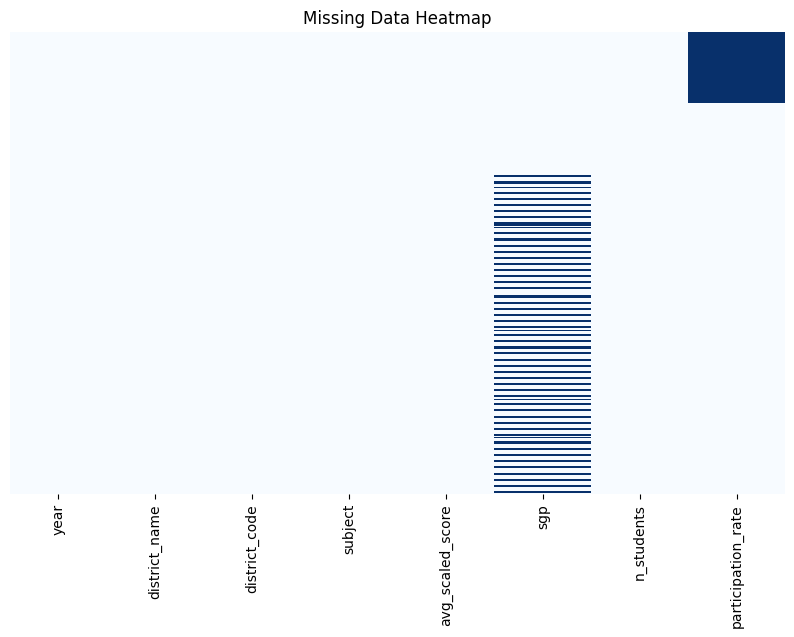

In [34]:
# Heatmap of missing values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(mcas_df.isnull(), cbar=False, yticklabels=False, cmap="Blues")
plt.title("Missing Data Heatmap")
plt.show()

### Note on Missing Data

- `sgp` is missing in **953 rows**, mostly due to lack of reporting for **science**.
- `participation_rate` is missing in **608 rows**, all from **2019**, when it was not published.

## **Confirm Science Missing SGP and Add SGP Flag**

In [35]:
# Confirm that science rows have no SGP values at all
science_sgp_null_ratio = mcas_df[mcas_df["subject"] == "science"]["sgp"].isnull().mean()
print(f"\nPercent of science rows missing SGP: {science_sgp_null_ratio:.2%}")


Percent of science rows missing SGP: nan%


In [36]:
# Add a binary indicator for whether SGP is available
mcas_df["sgp_available"] = ~mcas_df["sgp"].isnull()

## **Final Cleanups Before Analysis**

In [37]:
# Lowercase and rename subjects
mcas_df["subject"] = mcas_df["subject"].str.strip().str.lower()
mcas_df["subject"] = mcas_df["subject"].replace({
    "ela": "english",
    "math": "math",
    "sci": "science"
})


In [38]:
mcas_df["n_students"] = pd.to_numeric(mcas_df["n_students"], errors="coerce")

# **Exploratory Data Analysis (EDA)**

In [39]:
import matplotlib.pyplot as plt

# Define a function to save plots to Visuals & Reports folder
def save_plot(fig, filename):
    output_dir = "/content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis/visuals & reports"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, bbox_inches="tight")
    print(f"Saved: {filepath}")

## **EDA 1: Score Trends, Distributions, and District Coverage**

### **1. Number of Districts per Year**

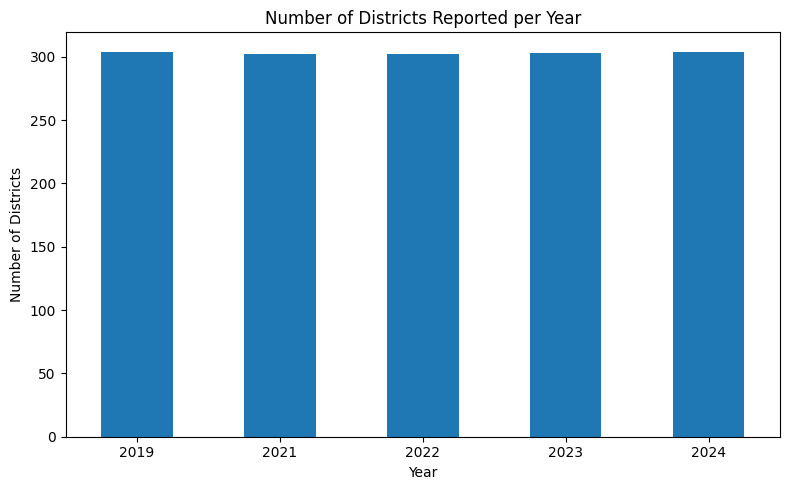

Saved: /content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis/visuals & reports/n_districts_reported_per_year.png


In [40]:
# How many districts reported each year?
district_counts = mcas_df.groupby("year")["district_code"].nunique()

district_counts.plot(kind="bar", figsize=(8, 5))
plt.title("Number of Districts Reported per Year")
plt.ylabel("Number of Districts")
plt.xlabel("Year")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

save_plot(fig, "n_districts_reported_per_year.png")

### **2. Average Scaled Score by Subject Over Time**

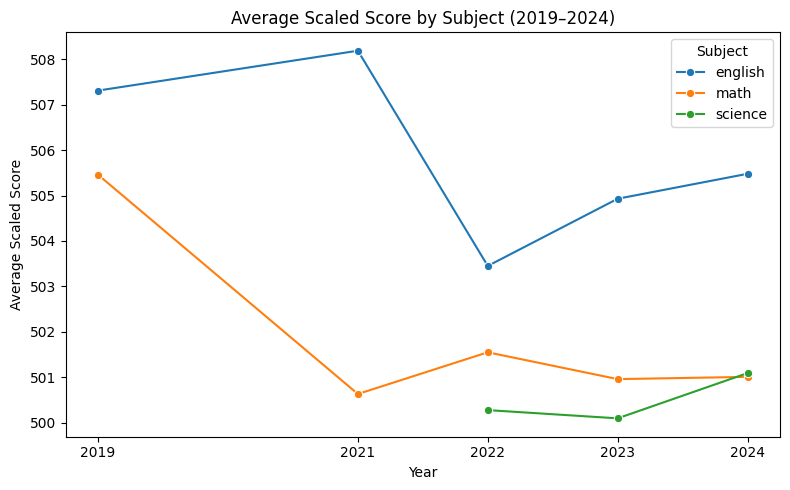

Saved: /content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis/visuals & reports/average_scaled_score_by_subject.png


In [41]:
# Calculate mean scaled score per subject per year
score_trends = (
    mcas_df
    .groupby(["year", "subject"])["avg_scaled_score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.lineplot(data=score_trends, x="year", y="avg_scaled_score", hue="subject", marker="o")
plt.title("Average Scaled Score by Subject (2019–2024)")
plt.ylabel("Average Scaled Score")
plt.xlabel("Year")
plt.xticks(score_trends["year"].unique())
plt.legend(title="Subject")
plt.tight_layout()
plt.show()

save_plot(fig, "average_scaled_score_by_subject.png")

### **3. Score Distribution by Subject (Latest Year)**

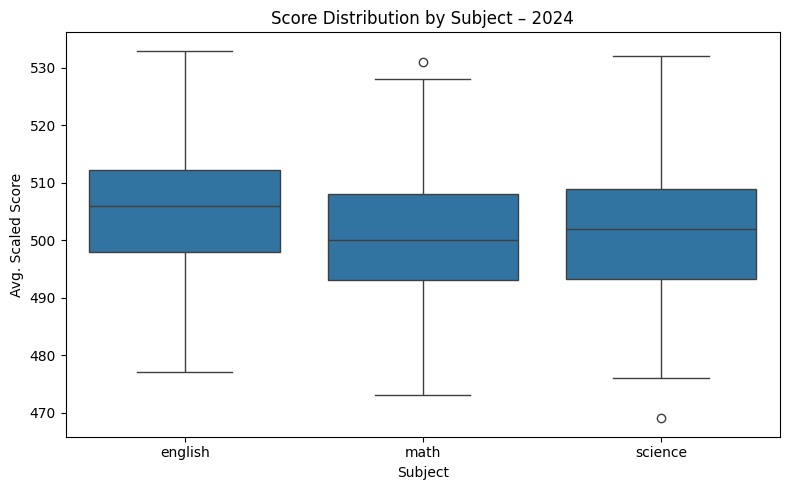

Saved: /content/drive/My Drive/MTurner Portfolio/MCAS Score Analysis/visuals & reports/score_distribution_by_subject_2024.png


In [42]:
latest_year = mcas_df["year"].max()
latest_data = mcas_df[mcas_df["year"] == latest_year]

plt.figure(figsize=(8, 5))
sns.boxplot(data=latest_data, x="subject", y="avg_scaled_score")
plt.title(f"Score Distribution by Subject – {latest_year}")
plt.ylabel("Avg. Scaled Score")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

save_plot(fig, "score_distribution_by_subject_2024.png")

In [45]:
# Focus on 2024 data
df_2024 = mcas_df[mcas_df["year"] == 2024].copy()

# Identify outliers by subject using IQR
def detect_outliers_iqr(df, subject):
    subset = df[df["subject"] == subject]
    q1 = subset["avg_scaled_score"].quantile(0.25)
    q3 = subset["avg_scaled_score"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = subset[
        (subset["avg_scaled_score"] < lower_bound) |
        (subset["avg_scaled_score"] > upper_bound)
    ]
    return outliers

# Check outliers for each subject
outlier_dict = {}
for subj in ["math", "english", "science"]:
    outlier_dict[subj] = detect_outliers_iqr(df_2024, subj)

# Preview outliers
for subj, df in outlier_dict.items():
    print(f"\n--- {subj.upper()} OUTLIERS ---")
    display(df[["district_name", "avg_scaled_score", "n_students"]].sort_values("avg_scaled_score"))


--- MATH OUTLIERS ---


,district_name,avg_scaled_score,n_students
3432,Lexington,531.0,602.0



--- ENGLISH OUTLIERS ---


,district_name,avg_scaled_score,n_students



--- SCIENCE OUTLIERS ---


,district_name,avg_scaled_score,n_students
3774,Southbridge,469.0,94.0


### **Notable 2024 Outlier Districts**

Two district-level outliers were identified in the 2024 MCAS scaled scores:

- **Lexington (Math – 531.0):**  
  Lexington consistently ranks among the top-performing districts in Massachusetts. Its math score stands out as a **high-performance outlier**, reflecting a strong academic reputation and likely access to robust educational resources.

- **Southbridge (Science – 469.0):**  
  Southbridge is a state-intervention district with a history of academic struggles and state oversight. Its science score is a **low-performance outlier**, highlighting persistent challenges and potential areas for targeted improvement or resource investment.

# **Modeling**

### Predictive Modeling Objective

The goal of this analysis is to build a model that predicts the average scaled MCAS score (`avg_scaled_score`) for a given district-subject-year entry.

#### Target Variable:
- `avg_scaled_score` – the district-wide average scaled MCAS score for a specific subject and year

#### Predictor Variables:
- `year` – academic year (e.g., 2019–2024)
- `participation_rate` – percentage of eligible students who took the exam
- `n_students` – number of students included in the reported results
- `subject` – encoded as categorical features (math, english, science)

We begin with a linear regression model to assess feature relationships and predictive potential, followed by optional exploration of nonlinear models such as random forests.

In [46]:
# Drop rows with missing values in key features
model_df = mcas_df[
    mcas_df[["avg_scaled_score", "participation_rate", "n_students"]].notnull().all(axis=1)
].copy()

# One-hot encode subject
model_df = pd.get_dummies(model_df, columns=["subject"], drop_first=True)

# Define features and target
features = ["year", "participation_rate", "n_students"] + [col for col in model_df.columns if col.startswith("subject_")]
target = "avg_scaled_score"

X = model_df[features]
y = model_df[target]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 3))

Linear Regression RMSE: 9.49
R² Score: 0.138


In [51]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

coefficients

,Feature,Coefficient
4,subject_science,-5.457428
3,subject_math,-4.128630
0,year,-0.828493
1,participation_rate,0.556139
2,n_students,0.004263


## **Subject Specific Models**

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Store results
subject_results = {}

# Loop through each subject
for subj in ["math", "english", "science"]:
    print(f"\n--- {subj.upper()} MODEL ---")

    # Filter to subject and drop missing
    df_subj = mcas_df[
        (mcas_df["subject"] == subj) &
        mcas_df[["avg_scaled_score", "participation_rate", "n_students"]].notnull().all(axis=1)
    ].copy()

    # Features and target
    X = df_subj[["year", "participation_rate", "n_students"]]
    y = df_subj["avg_scaled_score"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Coefficients
    coefs = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    }).sort_values("Coefficient", key=abs, ascending=False)

    # Save results
    subject_results[subj] = {
        "model": model,
        "rmse": rmse,
        "r2": r2,
        "coefs": coefs
    }

    # Print summary
    print("RMSE:", round(rmse, 2))
    print("R² Score:", round(r2, 3))
    display(coefs)


--- MATH MODEL ---
RMSE: 9.86
R² Score: 0.121


,Feature,Coefficient
0,year,-0.856041
1,participation_rate,0.548235
2,n_students,0.006466



--- ENGLISH MODEL ---
RMSE: 9.07
R² Score: 0.106


,Feature,Coefficient
0,year,-1.221237
1,participation_rate,0.395756
2,n_students,0.000183



--- SCIENCE MODEL ---
RMSE: 9.84
R² Score: 0.055


,Feature,Coefficient
1,participation_rate,1.401629
0,year,-0.028639
2,n_students,0.009517


### **Why Switch from Linear Regression to Random Forest**

The linear regression models showed low R² values (5–14%), meaning they explained only a small portion of the variance in average scaled scores. This suggests that the relationship between features like participation rate, year, and student count and the outcome is not well-captured by a linear model. We now move to Random Forest regression, which can better handle nonlinear relationships and interactions between variables without requiring manual transformation or feature engineering.

In [77]:
from sklearn.ensemble import RandomForestRegressor

# Reuse model_df with one-hot encoded subjects
model_df = mcas_df[
    mcas_df[["avg_scaled_score", "participation_rate", "n_students"]].notnull().all(axis=1)
].copy()

# One-hot encode subject
model_df = pd.get_dummies(model_df, columns=["subject"], drop_first=True)

# Define features and target
features = ["year", "participation_rate", "n_students"] + [col for col in model_df.columns if col.startswith("subject_")]
target = "avg_scaled_score"

X = model_df[features]
y = model_df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

print("Random Forest RMSE:", round(rmse_rf, 2))
print("Random Forest R² Score:", round(r2_rf, 3))

Random Forest RMSE: 9.67
Random Forest R² Score: 0.105


In [54]:
# Feature importances
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

display(importances)

,Feature,Importance
2,n_students,0.592437
1,participation_rate,0.208494
0,year,0.126683
3,subject_math,0.040209
4,subject_science,0.032177


### **Random Forest Model Summary and Next Steps**

The random forest model resulted in an RMSE of 9.67 and an R² score of 0.105, suggesting that the model explains only about 10.5% of the variation in MCAS average scaled scores. While random forests are powerful at capturing nonlinear patterns and interactions, these results indicate that the features used so far—such as participation rate, number of students tested, year, and subject—are not strong predictors of performance on their own.

This underperformance likely reflects the absence of key district-level context variables that influence academic outcomes. Important missing predictors may include:

- **Demographic indicators** such as low-income rates, English language learner (ELL) percentages, and racial/ethnic composition
- **Structural and organizational factors** such as school or district type (e.g., charter, state-run, urban vs. suburban)
- **Instructional investment and funding**, including per pupil expenditures and access to advanced coursework

To improve model performance and deepen our understanding, the next step is to enrich the dataset with demographic and population-level features. We will use the statewide dataset provided by the Massachusetts Department of Elementary and Secondary Education via the [Education-to-Career Data Portal](https://educationtocareer.data.mass.gov/Students-and-Teachers/Enrollment-Grade-Race-Ethnicity-Gender-and-Selecte/t8td-gens) to add relevant enrollment and demographic context by district and year.

## **Enrollment Data**

In [120]:
# Load enrollment file
enrollment_path = os.path.join(data_dir, "Enrollment_Grade_Race_Ethnicity_Gender_and_Selected_Populations.csv")
enroll_df = pd.read_csv(enrollment_path)

# Convert all column names to lowercase
enroll_df.columns = enroll_df.columns.str.lower()

# Filter by MCAS testing years (use latter part of school year)
target_years = ['2019', '2021', '2022', '2023', '2024']
enroll_df = enroll_df[
    (enroll_df["sy"].astype(str).isin(target_years)) &
    (enroll_df["org_type"] == "District")
]

# Select and rename relevant columns
enroll_filtered = enroll_df[[
    "sy", "dist_code", "dist_name", "g10_cnt",
    "lowincome_pct", "el_pct", "sped_pct", "hn_pct",
    "flne_pct", "white_pct", "aframe_pct", "hispanic_pct", "asian_pct"
]].rename(columns={
    "sy": "year",
    "dist_code": "district_code",
    "dist_name": "district_name",
    "g10_cnt": "grade10_enrollment"
})

# Convert year to numeric
enroll_filtered["year"] = enroll_filtered["year"].astype(int)

# Preview cleaned enrollment dataset
print("Filtered shape:", enroll_filtered.shape)
display(enroll_filtered.head())

Filtered shape: (2003, 13)


,year,district_code,district_name,grade10_enrollment,lowincome_pct,el_pct,sped_pct,hn_pct,flne_pct,white_pct,aframe_pct,hispanic_pct,asian_pct
2244,2024,4450000,Abby Kelley Foster Charter Public (District),83.0,0.577,0.222,0.110,0.704,0.692,0.119,0.568,0.233,0.030
2246,2024,10000,Abington,135.0,0.325,0.117,0.188,0.468,0.185,0.725,0.062,0.154,0.025
2252,2024,4120000,Academy Of the Pacific Rim Charter Public (Dis...,56.0,0.623,0.120,0.200,0.730,0.355,0.039,0.643,0.286,0.000
2254,2024,6000000,Acton-Boxborough,425.0,0.115,0.077,0.161,0.317,0.240,0.497,0.028,0.086,0.331
2264,2024,30000,Acushnet,0.0,0.309,0.001,0.164,0.412,0.015,0.882,0.012,0.063,0.006


In [121]:
# Check for nulls across all columns
null_counts = enroll_filtered.isnull().sum()
null_counts = null_counts[null_counts > 0]

if null_counts.empty:
    print("No missing values in model_df.")
else:
    print("Missing values found:")
    display(null_counts)

Missing values found:


,0
lowincome_pct,806
el_pct,2
sped_pct,2
hn_pct,2
flne_pct,2


In [122]:
# Subset rows where lowincome_pct is missing
missing_lowincome = enroll_filtered[enroll_filtered["lowincome_pct"].isnull()]

# Count by year
print("Missing LOWINCOME_PCT by Year:")
print(missing_lowincome["year"].value_counts().sort_index())

# Preview some district names
print("\nExample Districts with Missing LOWINCOME_PCT:")
print(missing_lowincome["district_name"].value_counts().tail(50))


Missing LOWINCOME_PCT by Year:
year
2019    406
2021    400
Name: count, dtype: int64

Example Districts with Missing LOWINCOME_PCT:
district_name
Uxbridge                                                         2
Upper Cape Cod Regional Vocational Technical                     2
Up-Island Regional                                               2
UP Academy Charter School of Dorchester (District)               2
UP Academy Charter School of Boston (District)                   2
Tyngsborough                                                     2
Truro                                                            2
Triton                                                           2
Tri-County Regional Vocational Technical                         2
Topsfield                                                        2
Tisbury                                                          2
Tewksbury                                                        2
Wrentham                                         

In [123]:
# Create a pivot table of lowincome_pct by district and year
lowincome_trend = enroll_filtered.pivot_table(
    index="district_name",
    columns="year",
    values="lowincome_pct"
).sort_index()

# Display a sample of the table
lowincome_trend.head(20)

year,2022,2023,2024
district_name,,,
Abby Kelley Foster Charter Public (District),0.689,0.589,0.577
Abington,0.393,0.344,0.325
Academy Of the Pacific Rim Charter Public (District),0.641,0.585,0.623
Acton-Boxborough,0.109,0.106,0.115
Acushnet,0.370,0.332,0.309
Advanced Math and Science Academy Charter (District),0.147,0.160,0.173
Agawam,0.439,0.407,0.431
Alma del Mar Charter School (District),0.764,0.739,0.728
Amesbury,0.336,0.338,0.334


In [124]:
# Filter relevant years and districts
target_years = ['2022', '2023', '2024']
enroll_df = enroll_df[
    (enroll_df["sy"].astype(str).isin(target_years)) &
    (enroll_df["org_type"] == "District")
]

# Select and rename relevant columns
enroll_filtered = enroll_df[[
    "sy", "dist_code", "dist_name", "lowincome_pct"
]].rename(columns={
    "sy": "year",
    "dist_code": "district_code",
    "dist_name": "district_name"
})

# Convert year to integer
enroll_filtered["year"] = enroll_filtered["year"].astype(int)

# Pivot to get year-by-year comparison
pivot = enroll_filtered.pivot(index="district_name", columns="year", values="lowincome_pct")

# Calculate percent change between years
pivot["pct_change_22_23"] = ((pivot[2023] - pivot[2022]) / pivot[2022]).abs()
pivot["pct_change_23_24"] = ((pivot[2024] - pivot[2023]) / pivot[2023]).abs()

# Flag districts with >20% change year over year
anomalies = pivot[(pivot["pct_change_22_23"] > 0.2) | (pivot["pct_change_23_24"] > 0.2)]

display(anomalies)

year,2022,2023,2024,pct_change_22_23,pct_change_23_24
district_name,,,,,
Cape Cod Lighthouse Charter (District),0.276,0.232,0.466,0.159420,1.008621
Christa McAuliffe Charter School (District),0.786,0.526,0.455,0.330789,0.134981
Concord,0.099,0.084,0.107,0.151515,0.273810
Deerfield,0.224,0.194,0.236,0.133929,0.216495
Dover-Sherborn,0.058,0.056,0.071,0.034483,0.267857
Florida,0.558,0.457,0.341,0.181004,0.253829
Four Rivers Charter Public (District),0.344,0.301,0.364,0.125000,0.209302
Hamilton-Wenham,0.106,0.083,0.080,0.216981,0.036145
Harvard,0.083,0.075,0.097,0.096386,0.293333


In [129]:
model_df["lowincome_pct"] = full_df["lowincome_pct_filled"]
print(model_df[["lowincome_pct"]].isnull().sum())

lowincome_pct    2685
dtype: int64


# **Geospatial Mapping**

In [16]:
# Load MA towns shapefile or geojson
ma_map = gpd.read_file("../Data Files/ma_towns.geojson")

# Merge with average scores
geo_df = ma_map.merge(merged_df.groupby("town")[["mean_scaled_score_math"]].mean(), left_on="TOWN", right_on="town")

# Plot map
geo_df.plot(column='mean_scaled_score_math', cmap='Blues', legend=True)
plt.title("Average 10th Grade Math Score by Town")
plt.axis('off')
plt.show()

DataSourceError: ../Data Files/ma_towns.geojson: No such file or directory

# **Summary and Next Steps**

## Summary
- Scores have increased slightly statewide over the last 10 years, but large gaps persist.
- Income and English learner status are strong predictors of performance.
- Mapping reveals consistent regional disparities between urban and suburban areas.

## Next Steps
- Add interactive dashboards in Tableau
- Extend to other grade levels or subjects
- Incorporate school funding or staffing data